# NLP Final Project - Email Spam Corpera

By: Brandon Croarkin, Michelle Mak, and T.S. Yeap

In [238]:
# open python and nltk packages needed for processing
import os
import sys
import random
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import sentence_polarity
from nltk.collocations import *
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [164]:
#os.chdir(r'C:\Users\brcro\OneDrive\Documents\Syracuse\IST 664 - Natural Language Processing\Final Project\FinalProjectData\EmailSpamCorpora\corpus')
os.chdir(r'C:\Users\Brandon Croarkin\Documents\Education\Syracuse\NLP\Final Project\FinalProjectData\EmailSpamCorpora\corpus')

In [165]:
os.listdir()

['.DS_Store', 'ham', 'spam']

# Creating Functions

In [166]:
# define features (keywords) of a document for a BOW/unigram baseline
# each feature is 'contains(keyword)' and is true or false depending
# on whether that keyword is in the document
def document_features(document, word_features):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    return features

In [167]:
# function that takes a word and returns true if it consists only
# of non-alphabetic characters  (assumes import re)
def alpha_filter(w):
    # pattern to match word of non-alphabetical characters
    pattern = re.compile('^[^a-z]+$')
    if (pattern.match(w)):
        return True
    else:
        return False

In [168]:
# define features that include words as before 
# add the most frequent significant bigrams
# this function takes the list of words in a document as an argument and returns a feature dictionary
# it depends on the variables word_features and bigram_features
def bigram_document_features(document, word_features, bigram_features):
    document_words = set(document)
    document_bigrams = nltk.bigrams(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    for bigram in bigram_features:
        features['B_{}_{}'.format(bigram[0], bigram[1])] = (bigram in document_bigrams)    
    return features

In [169]:
# this function takes a document list of words and returns a feature dictionary
# it runs the default pos tagger (the Stanford tagger) on the document
#   and counts 4 types of pos tags to use as features
def POS_features(document, word_features):
    document_words = set(document)
    tagged_words = nltk.pos_tag(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    numNoun = 0
    numVerb = 0
    numAdj = 0
    numAdverb = 0
    for (word, tag) in tagged_words:
        if tag.startswith('N'): numNoun += 1
        if tag.startswith('V'): numVerb += 1
        if tag.startswith('J'): numAdj += 1
        if tag.startswith('R'): numAdverb += 1
    features['nouns'] = numNoun
    features['verbs'] = numVerb
    features['adjectives'] = numAdj
    features['adverbs'] = numAdverb
    return features

In [170]:
## cross-validation ##
# this function takes the number of folds, the feature sets
# it iterates over the folds, using different sections for training and testing in turn
#   it prints the precision, recall and F score for each fold
#.  (it does not compute the average over the folds)
def cross_validation_PRF(num_folds, featuresets):
    subset_size = int(len(featuresets)/num_folds)
    print('Each fold size:', subset_size)
    #accuracy_list = []
    # iterate over the folds
    for i in range(num_folds):
        test_this_round = featuresets[(i*subset_size):][:subset_size]
        train_this_round = featuresets[:(i*subset_size)] + featuresets[((i+1)*subset_size):]
        # train using train_this_round
        classifier = nltk.NaiveBayesClassifier.train(train_this_round)
        # evaluate against test_this_round to produce the gold and predicted labels
        goldlist = []
        predictedlist = []
        for (features, label) in test_this_round:
            goldlist.append(label)
            predictedlist.append(classifier.classify(features))

        # call the function with our data
        eval_measures(goldlist, predictedlist)
    # this version doesn't save measures and compute averages

In [171]:
# this function returns a dictionary where you can look up words and get back 
#     the four items of subjectivity information described above
def readSubjectivity(path):
    flexicon = open(path, 'r')
    # initialize an empty dictionary
    sldict = { }
    for line in flexicon:
        fields = line.split()   # default is to split on whitespace
        # split each field on the '=' and keep the second part as the value
        strength = fields[0].split("=")[1]
        word = fields[2].split("=")[1]
        posTag = fields[3].split("=")[1]
        stemmed = fields[4].split("=")[1]
        polarity = fields[5].split("=")[1]
        if (stemmed == 'y'):
            isStemmed = True
        else:
            isStemmed = False
        # put a dictionary entry with the word as the keyword
        #     and a list of the other values
        sldict[word] = [strength, posTag, isStemmed, polarity]
    return sldict

In [172]:
# define features that include word counts of subjectivity words
# negative feature will have number of weakly negative words +
#    2 * number of strongly negative words
# positive feature has similar definition
#    not counting neutral words

def SL_features(document, word_features, SL):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    # count variables for the 4 classes of subjectivity
    weakPos = 0
    strongPos = 0
    weakNeg = 0
    strongNeg = 0
    for word in document_words:
        if word in SL:
            strength, posTag, isStemmed, polarity = SL[word]
            if strength == 'weaksubj' and polarity == 'positive':    
                weakPos += 1
            if strength == 'strongsubj' and polarity == 'positive':  
                strongPos += 1
            if strength == 'weaksubj' and polarity == 'negative':    
                weakNeg += 1
            if strength == 'strongsubj' and polarity == 'negative':  
                strongNeg += 1
            features['positivecount'] = weakPos + (2 * strongPos)
            features['negativecount'] = weakNeg + (2 * strongNeg)      
    return features

In [173]:
def eval_measures(gold, predicted):
    # get a list of labels
    labels = list(set(gold))
    # these lists have values for each label
    recall_list = []
    precision_list = []
    F1_list = []
    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        recall = TP / (TP + FP)
        precision = TP / (TP + FN)
        recall_list.append(recall)
        precision_list.append(precision)
        F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    print('Label\tPrecision\tRecall\t\tF1')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))

In [174]:
# this function takes the number of folds, the feature sets
# it iterates over the folds, using different sections for training and testing in turn
#   it prints the accuracy for each fold and the average accuracy at the end
def cross_validation_accuracy(num_folds, featuresets):
    subset_size = int(len(featuresets)/num_folds)
    print('Each fold size:', subset_size)
    accuracy_list = []
    # iterate over the folds
    for i in range(num_folds):
        test_this_round = featuresets[(i*subset_size):][:subset_size]
        train_this_round = featuresets[:(i*subset_size)] + featuresets[((i+1)*subset_size):]
        # train using train_this_round
        classifier = nltk.NaiveBayesClassifier.train(train_this_round)
        # evaluate against test_this_round and save accuracy
        accuracy_this_round = nltk.classify.accuracy(classifier, test_this_round)
        print (i, accuracy_this_round)
        accuracy_list.append(accuracy_this_round)
    # find mean accuracy over all rounds
    print ('mean accuracy', sum(accuracy_list) / num_folds)

In [175]:
# One strategy with negation words is to negate the word following the negation word
#   other strategies negate all words up to the next punctuation
# Strategy is to go through the document words in order adding the word features,
#   but if the word follows a negation words, change the feature to negated word
# Start the feature set with all 2000 word features and 2000 Not word features set to false

def NOT_features(document, word_features, negationwords):    
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = False
        features['V_NOT{}'.format(word)] = False
    # go through document words in order
    for i in range(0, len(document)):
        word = document[i]
        if ((i + 1) < len(document)) and ((word in negationwords) or (word.endswith("n't"))):
            i += 1
            features['V_NOT{}'.format(document[i])] = (document[i] in word_features)
        else:
            features['V_{}'.format(word)] = (word in word_features)
    return features

In [176]:
# Function writeFeatureSets:
# takes featuresets defined in the nltk and convert them to weka input csv file
#    any feature value in the featuresets should not contain ",", "'" or " itself
#    and write the file to the outpath location
#    outpath should include the name of the csv file
def writeFeatureSets(featuresets, outpath):
    # open outpath for writing
    f = open(outpath, 'w')
    # get the feature names from the feature dictionary in the first featureset
    featurenames = featuresets[0][0].keys()
    # create the first line of the file as comma separated feature names
    #    with the word class as the last feature name
    featurenameline = ''
    for featurename in featurenames:
        # replace forbidden characters with text abbreviations
        featurename = featurename.replace(',','CM')
        featurename = featurename.replace("'","DQ")
        featurename = featurename.replace('"','QU')
        featurenameline += featurename + ','
    featurenameline += 'class'
    # write this as the first line in the csv file
    f.write(featurenameline)
    f.write('\n')
    # convert each feature set to a line in the file with comma separated feature values,
    # each feature value is converted to a string
    #   for booleans this is the words true and false
    #   for numbers, this is the string with the number
    for featureset in featuresets:
        featureline = ''
        for key in featurenames:
            featureline += str(featureset[0][key]) + ','
        featureline += featureset[1]
        # write each feature set values to the file
        f.write(featureline)
        f.write('\n')
    f.close()

In [285]:
# define features (keywords) of a document for a BOW/unigram baseline
# each feature is the TF-IDF score if word is in document
def TFIDF_document_features(document, TF_IDF_dict):
    document_words = set(document)
    features = {}
    for k, v in topkeysnormalized:
        if (k in document_words):
            features['V_{}'.format(k)] = v
        else:
            features['V_{}'.format(k)] = 0
    return features

## Creating Word List

In [177]:
#dirPath = 'C:\\Users\\brcro\\OneDrive\\Documents\\Syracuse\\IST 664 - Natural Language Processing\\Final Project\\FinalProjectData\\EmailSpamCorpora\\corpus'
dirPath = 'C:\\Users\\Brandon Croarkin\\Documents\\Education\\Syracuse\\NLP\\Final Project\\FinalProjectData\\EmailSpamCorpora\\corpus'
limitStr = 1500

In [178]:
# convert the limit argument from a string to an int
limit = int(limitStr)
  
# start lists for spam and ham email texts
hamtexts = []
spamtexts = []
os.chdir(dirPath)
# process all files in directory that end in .txt up to the limit
#    assuming that the emails are sufficiently randomized
for file in os.listdir("./spam"):
    if (file.endswith(".txt")) and (len(spamtexts) < limit):
        # open file for reading and read entire file into a string
        f = open("./spam/"+file, 'r', encoding="latin-1")
        spamtexts.append (f.read())
        f.close()
for file in os.listdir("./ham"):
    if (file.endswith(".txt")) and (len(hamtexts) < limit):
        # open file for reading and read entire file into a string
        f = open("./ham/"+file, 'r', encoding="latin-1")
        hamtexts.append (f.read())
        f.close()

# print number emails read
print ("Number of spam files:",len(spamtexts))
print ("Number of ham files:",len(hamtexts))

Number of spam files: 1500
Number of ham files: 1500


In [179]:
# create list of mixed spam and ham email documents as (list of words, label)
emaildocs = []
# add all the spam
for spam in spamtexts:
    tokens = nltk.word_tokenize(spam)
    emaildocs.append((tokens, 'spam'))
# add all the regular emails
for ham in hamtexts:
    tokens = nltk.word_tokenize(ham)
    emaildocs.append((tokens, 'ham'))
    
# randomize the list
random.shuffle(emaildocs)
  
# print a few token lists
for email in emaildocs[:1]:
    print(email)

(['Subject', ':', 'entex', 'for', 'jan', '.', '2000', 'this', 'spreadsheet', 'shows', 'the', 'current', 'estimates', 'are', 'approximately', '12', ',', '000', '/', 'day', 'short', 'of', 'what', 'the', 'estimates', 'would', 'be', 'with', 'the', 'revised', 'entex', 'factor', '.', 'call', 'me', 'if', 'you', 'have', 'any', 'questions', '.', 'i', 'will', 'work', 'to', 'get', 'the', 'revised', 'estimates', 'into', 'pops', 'today', '.', 'gary'], 'ham')


## Data Pre-Processing 

### All Words 

In [180]:
# get all words from all emails and put into a frequency 
#   note lowercase, but no stemming or stopwords
all_words_list = [word for (sent,cat) in emaildocs for word in sent]
all_words = nltk.FreqDist(all_words_list)

# get the 2000 most frequently appearing keywords in the corpus
word_items = all_words.most_common(2000)
word_features = [word for (word,count) in word_items]
print(word_features[:50])

['-', '.', '/', ',', ':', 'the', 'to', 'ect', 'and', 'of', '@', 'a', 'for', '?', 'you', 'in', 'this', 'is', 'hou', 'on', 'i', "'", ')', '=', '(', 'enron', 'Subject', '!', 'be', 'your', '2000', 'that', 'with', 'from', '_', 'will', 'have', 'we', 's', 'as', 'are', 'it', '$', '>', 'or', '3', 'at', 'not', 'by', 'please']


### Adding Negation Features 

In [181]:
# this list of negation words includes some "approximate negators" like hardly and rarely
negationwords = ['no', 'not', 'never', 'none', 'nowhere', 'nothing', 'noone', 'rather', 'hardly', 'scarcely', 'rarely', 'seldom', 'neither', 'nor']

In [182]:
new_all_words_list = [word for word in all_words_list if word not in newstopwords]
new_all_words = nltk.FreqDist(new_all_words_list)
new_word_items = new_all_words.most_common(2000)
negation_word_features = [word for (word,count) in new_word_items]
print(negation_word_features[:30])

['-', '.', '/', ',', ':', 'ect', '@', '?', 'hou', "'", ')', '=', '(', 'enron', 'Subject', '!', '2000', '_', '$', '>', '3', 'not', 'please', '``', 'com', '|', '1', ';', '#', '2']


### Removing Stop Words 

In [183]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

179

In [184]:
newstopwords = [word for word in stopwords if word not in negationwords]
len(newstopwords)

176

In [185]:
new_all_words_list = [word for word in all_words_list if word not in newstopwords]
new_all_words = nltk.FreqDist(new_all_words_list)
new_word_items = new_all_words.most_common(2000)
no_stop_word_features = [word for (word,count) in new_word_items]

In [186]:
print(no_stop_word_features[:30])

['-', '.', '/', ',', ':', 'ect', '@', '?', 'hou', "'", ')', '=', '(', 'enron', 'Subject', '!', '2000', '_', '$', '>', '3', 'not', 'please', '``', 'com', '|', '1', ';', '#', '2']


### Removing Non-Alpha Characters 

In [187]:
# Filtered word feature
filtered_words_list = [word for (sent, cat) in emaildocs for word in sent if not alpha_filter(word)]
print(filtered_words_list[:100])

['Subject', 'entex', 'for', 'jan', 'this', 'spreadsheet', 'shows', 'the', 'current', 'estimates', 'are', 'approximately', 'day', 'short', 'of', 'what', 'the', 'estimates', 'would', 'be', 'with', 'the', 'revised', 'entex', 'factor', 'call', 'me', 'if', 'you', 'have', 'any', 'questions', 'i', 'will', 'work', 'to', 'get', 'the', 'revised', 'estimates', 'into', 'pops', 'today', 'gary', 'Subject', 'nomination', 'tuesday', 'this', 'is', 'to', 'nominate', 'mmbtu', 'd', 'for', 'into', 'eastrans', 'mmbtu', 'd', 'will', 'be', 'redelivered', 'into', 'pg', 'e', 'the', 'rest', 'into', 'hpl', 'from', 'fuels', 'cotton', 'valley', 'we', 'plan', 'to', 'begin', 'receiving', 'the', 'gas', 'at', 'pm', 'or', 'so', 'and', 'take', 'more', 'volume', 'to', 'average', 'the', 'nominated', 'quantity', 'for', 'the', 'day', 'as', 'i', 'indicated', 'on', 'the']


In [188]:
filtered_words = nltk.FreqDist(filtered_words_list)
print(len(filtered_words))

41065


In [189]:
filtered_word_items = filtered_words.most_common(1500)
filtered_word_features = [word for (word,count) in filtered_word_items]

## Experiments

### 1. Unigram Features 

In [190]:
# use document_features function to create unigram feature sets for all sentences
featuresets = [(document_features(d, word_features), c) for (d, c) in emaildocs]

In [191]:
# train a classifier and report accuracy
train_set, test_set = featuresets[2700:], featuresets[:2700]
classifier = nltk.NaiveBayesClassifier.train(train_set)
nltk.classify.accuracy(classifier, test_set)

0.9596296296296296

In [192]:
classifier.show_most_informative_features(30)

Most Informative Features
                  V_2000 = True              ham : spam   =     20.7 : 1.0
                  V_http = True             spam : ham    =     20.5 : 1.0
                    V_pm = True              ham : spam   =     19.9 : 1.0
             V_questions = True              ham : spam   =     18.8 : 1.0
                V_volume = True              ham : spam   =     16.8 : 1.0
                   V_gas = True              ham : spam   =     14.8 : 1.0
                     V_* = True             spam : ham    =     14.5 : 1.0
                   V_ami = True              ham : spam   =     14.1 : 1.0
                  V_file = True              ham : spam   =     14.1 : 1.0
                 V_offer = True             spam : ham    =     13.8 : 1.0
                    V_07 = True              ham : spam   =     13.5 : 1.0
                    V_06 = True              ham : spam   =     12.4 : 1.0
                  V_many = True             spam : ham    =     11.1 : 1.0

### 2. Unigram with Non-Alpha Characters Removed 

In [193]:
featuresets = [(document_features(d, filtered_word_features), c) for (d, c) in emaildocs]

In [194]:
new_train_set, new_test_set = featuresets[2700:], featuresets[:2700]
classifier1 = nltk.NaiveBayesClassifier.train(new_train_set)
nltk.classify.accuracy(classifier1, new_test_set)

0.9574074074074074

In [195]:
# train classifier and show performance in cross-validation
num_folds = 5
cross_validation_PRF(num_folds, featuresets)

Each fold size: 600
Label	Precision	Recall		F1
spam 	      0.981      0.943      0.962
ham 	      0.932      0.978      0.954
Label	Precision	Recall		F1
ham 	      0.935      0.997      0.965
spam 	      0.997      0.935      0.965
Label	Precision	Recall		F1
ham 	      0.936      0.993      0.964
spam 	      0.993      0.940      0.966
Label	Precision	Recall		F1
ham 	      0.933      1.000      0.966
spam 	      1.000      0.931      0.964
Label	Precision	Recall		F1
ham 	      0.943      0.996      0.969
spam 	      0.997      0.947      0.971


### 3. Unigram with Negation Words Removed 

In [196]:
#Create feature set with Negation Word Features
new_NOT_featuresets = [(NOT_features(d, negation_word_features, negationwords), c) for (d, c) in emaildocs]

In [197]:
new_train_set, new_test_set = new_NOT_featuresets[2700:], new_NOT_featuresets[:2700]
classifier1 = nltk.NaiveBayesClassifier.train(new_train_set)
nltk.classify.accuracy(classifier1, new_test_set)

0.9688888888888889

In [198]:
classifier1.show_most_informative_features(30)

Most Informative Features
                  V_2000 = True              ham : spam   =     20.7 : 1.0
                  V_http = True             spam : ham    =     20.5 : 1.0
                    V_pm = True              ham : spam   =     19.9 : 1.0
             V_questions = True              ham : spam   =     18.8 : 1.0
                V_volume = True              ham : spam   =     16.8 : 1.0
                   V_gas = True              ham : spam   =     14.8 : 1.0
                     V_* = True             spam : ham    =     14.5 : 1.0
                   V_ami = True              ham : spam   =     14.1 : 1.0
                  V_file = True              ham : spam   =     14.1 : 1.0
                 V_offer = True             spam : ham    =     13.8 : 1.0
                    V_07 = True              ham : spam   =     13.5 : 1.0
                    V_06 = True              ham : spam   =     12.4 : 1.0
                  V_many = True             spam : ham    =     11.1 : 1.0

### 4. Unigram with Stop Words Removed

In [199]:
# use document_features function to create unigram feature sets for all sentences
# using word features with stop words removed
featuresets = [(document_features(d, no_stop_word_features), c) for (d, c) in emaildocs]

In [200]:
# train a classifier and report accuracy
train_set, test_set = featuresets[2700:], featuresets[:2700]
classifier = nltk.NaiveBayesClassifier.train(train_set)
nltk.classify.accuracy(classifier, test_set)

0.9622222222222222

In [201]:
classifier.show_most_informative_features(30)

Most Informative Features
                  V_2000 = True              ham : spam   =     20.7 : 1.0
                  V_http = True             spam : ham    =     20.5 : 1.0
                    V_pm = True              ham : spam   =     19.9 : 1.0
             V_questions = True              ham : spam   =     18.8 : 1.0
                V_volume = True              ham : spam   =     16.8 : 1.0
                   V_gas = True              ham : spam   =     14.8 : 1.0
                     V_* = True             spam : ham    =     14.5 : 1.0
                   V_ami = True              ham : spam   =     14.1 : 1.0
                  V_file = True              ham : spam   =     14.1 : 1.0
                 V_offer = True             spam : ham    =     13.8 : 1.0
                    V_07 = True              ham : spam   =     13.5 : 1.0
                    V_06 = True              ham : spam   =     12.4 : 1.0
                  V_many = True             spam : ham    =     11.1 : 1.0

### 5. Unigram with Negation Features and Stop Words Removed

In [202]:
#adding Negation features to word features with stop words removed
new_NOT_featuresets = [(NOT_features(d, new_word_features, negationwords), c) for (d, c) in emaildocs]

In [203]:
new_train_set, new_test_set = new_NOT_featuresets[2700:], new_NOT_featuresets[:2700]
classifier1 = nltk.NaiveBayesClassifier.train(new_train_set)
nltk.classify.accuracy(classifier1, new_test_set)

0.9688888888888889

### 6. Unigram with Larger Featureset

In [303]:
# get the 6000 most frequently appearing keywords in the corpus
word_items_large = all_words.most_common(6000)
word_features_large = [word for (word,count) in word_items_large]

In [304]:
# use document_features function to create unigram feature sets for all sentences
featuresets_large = [(document_features(d, word_features_large), c) for (d, c) in emaildocs]

In [307]:
#print the number of features to confirm that there are 6000 now
print(len(featuresets_large))
print(len(featuresets_large[0][0]))

3000
6000


In [306]:
# train a classifier and report accuracy
train_set, test_set = featuresets_large[2700:], featuresets_large[:2700]
classifier = nltk.NaiveBayesClassifier.train(train_set)
nltk.classify.accuracy(classifier, test_set)

0.9533333333333334

### 7. Bigram Features

In [204]:
#Create short cut variable name for the bigram association measure
bigram_measures = nltk.collocations.BigramAssocMeasures()
#Create bigram collocation finder using all_words_list
finder = BigramCollocationFinder.from_words(all_words_list)
#Use raw_freq to get bigrams
bigram_features = finder.nbest(bigram_measures.raw_freq, 500)

In [205]:
# use this function to create feature sets for all sentences
bigram_featuresets = [(bigram_document_features(d, word_features, bigram_features), c) for (d, c) in emaildocs]

In [206]:
# number of features for document 0
print(len(bigram_featuresets[0][0].keys()))

2500


In [207]:
bigram_featuresets[0][0]

{'V_-': False,
 'V_.': True,
 'V_/': True,
 'V_,': True,
 'V_:': True,
 'V_the': True,
 'V_to': True,
 'V_ect': False,
 'V_and': False,
 'V_of': True,
 'V_@': False,
 'V_a': False,
 'V_for': True,
 'V_?': False,
 'V_you': True,
 'V_in': False,
 'V_this': True,
 'V_is': False,
 'V_hou': False,
 'V_on': False,
 'V_i': True,
 "V_'": False,
 'V_)': False,
 'V_=': False,
 'V_(': False,
 'V_enron': False,
 'V_Subject': True,
 'V_!': False,
 'V_be': True,
 'V_your': False,
 'V_2000': True,
 'V_that': False,
 'V_with': True,
 'V_from': False,
 'V__': False,
 'V_will': True,
 'V_have': True,
 'V_we': False,
 'V_s': False,
 'V_as': False,
 'V_are': True,
 'V_it': False,
 'V_$': False,
 'V_>': False,
 'V_or': False,
 'V_3': False,
 'V_at': False,
 'V_not': False,
 'V_by': False,
 'V_please': False,
 'V_``': False,
 'V_com': False,
 'V_if': True,
 'V_|': False,
 'V_1': False,
 'V_;': False,
 'V_#': False,
 'V_our': False,
 'V_me': True,
 'V_2': False,
 'V_e': False,
 'V_subject': False,
 'V_gas': 

In [208]:
# train a classifier and report accuracy
train_set, test_set = bigram_featuresets[2700:], bigram_featuresets[:2700]
classifier = nltk.NaiveBayesClassifier.train(train_set)
nltk.classify.accuracy(classifier, test_set)

0.9585185185185185

### 8. Bigram Features with Non-Alpha Characters Removed

In [209]:
# use this function to create feature sets for all sentences
bigram_featuresets = [(bigram_document_features(d, filtered_word_features, bigram_features), c) for (d, c) in emaildocs]

In [210]:
# train a classifier and report accuracy
train_set, test_set = bigram_featuresets[2700:], bigram_featuresets[:2700]
classifier = nltk.NaiveBayesClassifier.train(train_set)
nltk.classify.accuracy(classifier, test_set)

0.9540740740740741

### 9. Bigram Features with Stop Words Removed

In [211]:
# use this function to create feature sets for all sentences
bigram_featuresets = [(bigram_document_features(d, no_stop_word_features, bigram_features), c) for (d, c) in emaildocs]

In [212]:
# train a classifier and report accuracy
train_set, test_set = bigram_featuresets[2700:], bigram_featuresets[:2700]
classifier = nltk.NaiveBayesClassifier.train(train_set)
nltk.classify.accuracy(classifier, test_set)

0.9596296296296296

### 10. Bigram Features with Negation Words

In [213]:
# use this function to create feature sets for all sentences
bigram_featuresets = [(bigram_document_features(d, negation_word_features, bigram_features), c) for (d, c) in emaildocs]

In [214]:
# perform the cross-validation on the featuresets with word features and generate accuracy
num_folds = 5
cross_validation_accuracy(num_folds, bigram_featuresets)

Each fold size: 600
0 0.9683333333333334
1 0.96
2 0.9666666666666667
3 0.9666666666666667
4 0.9733333333333334
mean accuracy 0.967


### 11. POS Tag Features 

In [215]:
# define feature sets using this function
POS_featuresets = [(POS_features(d, word_features), c) for (d, c) in emaildocs]
# number of features for document 0
print(len(POS_featuresets[0][0].keys()))

2004


In [216]:
# the first sentence
print(emaildocs[0])
# the pos tag features for this sentence
print('num nouns', POS_featuresets[0][0]['nouns'])
print('num verbs', POS_featuresets[0][0]['verbs'])
print('num adjectives', POS_featuresets[0][0]['adjectives'])
print('num adverbs', POS_featuresets[0][0]['adverbs'])

(['Subject', ':', 'entex', 'for', 'jan', '.', '2000', 'this', 'spreadsheet', 'shows', 'the', 'current', 'estimates', 'are', 'approximately', '12', ',', '000', '/', 'day', 'short', 'of', 'what', 'the', 'estimates', 'would', 'be', 'with', 'the', 'revised', 'entex', 'factor', '.', 'call', 'me', 'if', 'you', 'have', 'any', 'questions', '.', 'i', 'will', 'work', 'to', 'get', 'the', 'revised', 'estimates', 'into', 'pops', 'today', '.', 'gary'], 'ham')
num nouns 14
num verbs 10
num adjectives 3
num adverbs 1


In [217]:
# train and test the classifier
train_set, test_set = POS_featuresets[1500:], POS_featuresets[:1500]
classifier = nltk.NaiveBayesClassifier.train(train_set)
nltk.classify.accuracy(classifier, test_set)

0.962

In [218]:
# perform the cross-validation on the featuresets with word features and generate accuracy
num_folds = 5
cross_validation_accuracy(num_folds, POS_featuresets)

Each fold size: 600
0 0.97
1 0.9616666666666667
2 0.965
3 0.9666666666666667
4 0.9716666666666667
mean accuracy 0.967


### 12. POS Tag Features with Non-Alpha Characters Removed

In [219]:
# define feature sets using this POS function and filtered word features
POS_featuresets = [(POS_features(d, filtered_word_features), c) for (d, c) in emaildocs]

In [220]:
# perform the cross-validation on the featuresets with word features and generate accuracy
num_folds = 5
cross_validation_accuracy(num_folds, POS_featuresets)

Each fold size: 600
0 0.9533333333333334
1 0.9566666666666667
2 0.965
3 0.9666666666666667
4 0.9716666666666667
mean accuracy 0.9626666666666667


### 13. POS Tag Features with Stop Words Removed

In [221]:
# define feature sets using this POS function and no stop words features
POS_featuresets = [(POS_features(d, no_stop_word_features), c) for (d, c) in emaildocs]

In [222]:
# perform the cross-validation on the featuresets with word features and generate accuracy
num_folds = 5
cross_validation_accuracy(num_folds, POS_featuresets)

Each fold size: 600
0 0.9683333333333334
1 0.9683333333333334
2 0.9716666666666667
3 0.9716666666666667
4 0.975
mean accuracy 0.9709999999999999


### 14. POS Tag Features with Negation Words

In [223]:
# define feature sets using this POS function and no stop words features
POS_featuresets = [(POS_features(d, negation_word_features), c) for (d, c) in emaildocs]

In [224]:
# perform the cross-validation on the featuresets with word features and generate accuracy
num_folds = 5
cross_validation_accuracy(num_folds, POS_featuresets)

Each fold size: 600
0 0.9683333333333334
1 0.9683333333333334
2 0.9716666666666667
3 0.9716666666666667
4 0.975
mean accuracy 0.9709999999999999


### 15. Subjectivity 

In [225]:
path = "C:/Users/brcro/OneDrive/Documents/Syracuse/IST 664 - Natural Language Processing/Week 8 - Sentiment Analysis/Lab/subjclueslen1-HLTEMNLP05.tff"
SL = readSubjectivity(path)
# how many words are in the dictionary
len(SL.keys())

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/brcro/OneDrive/Documents/Syracuse/IST 664 - Natural Language Processing/Week 8 - Sentiment Analysis/Lab/subjclueslen1-HLTEMNLP05.tff'

In [ ]:
SL_featuresets = [(SL_features(d, word_features, SL), c) for (d, c) in emaildocs]
len(SL_featuresets)

In [ ]:
# this gives the label of document 0
print(SL_featuresets[0][1])
# number of features for document 0
len(SL_featuresets[0][0].keys())

In [ ]:
SL_featuresets[0][0]

In [ ]:
# train the classifier using these features
train_set, test_set = SL_featuresets[2700:], SL_featuresets[:2700]
classifier = nltk.NaiveBayesClassifier.train(train_set)
nltk.classify.accuracy(classifier, test_set)

### 16. Sentiment with Non-Alpha Characters Removed

In [ ]:
#word_features has non-alpha characters removed from code above
SL_featuresets = [(SL_features(d, word_features, SL), c) for (d, c) in emaildocs]

In [ ]:
# train the classifier using these features
train_set, test_set = SL_featuresets[2700:], SL_featuresets[:2700]
classifier = nltk.NaiveBayesClassifier.train(train_set)
nltk.classify.accuracy(classifier, test_set)

In [ ]:
# perform the cross-validation on the featuresets with word features and generate accuracy
num_folds = 10
cross_validation_accuracy(num_folds, SL_featuresets)

### 17. Sci-Kit Learn with Unigram Featureset

In [226]:
# use document_features function to create unigram feature sets for all sentences
featuresets = [(document_features(d, word_features), c) for (d, c) in emaildocs]

In [227]:
# write the feature sets to the csv file
outpath = 'C:\\Users\\Brandon Croarkin\\Documents\\Education\\Syracuse\\NLP\\Final Project\\FinalProjectData\\ExternalClassifier\SK_Features.csv'
writeFeatureSets(featuresets, outpath)

In [228]:
# read in the csv file to use with sk-learn
sk_featureset = pd.read_csv(outpath, encoding="latin-1")
sk_featureset.head()

,V_-,V_.,V_/,V_CM,V_:,V_the,V_to,V_ect,V_and,V_of,...,V_teams,V_mean,V_memo,V_liquids,V_situation,V_und,V_commission,V_wiil,V_deposit,class
0,False,True,True,True,True,True,True,False,False,True,...,False,False,False,False,False,False,False,False,False,ham
1,True,True,True,True,True,True,True,False,True,False,...,False,False,False,False,False,False,False,False,False,ham
2,True,True,True,True,True,True,True,False,True,True,...,False,False,False,False,False,False,False,False,False,ham
3,True,True,False,True,True,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,spam
4,True,True,False,True,True,True,True,False,True,True,...,False,False,False,False,False,False,False,False,False,ham


In [229]:
#Split out the data and the labels
X = pd.DataFrame(sk_featureset.iloc[:,:-1])
y = pd.factorize(sk_featureset.loc[:,'class'])[0]

In [230]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 70% training and 30% test

In [231]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

In [232]:
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [233]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9766666666666667


In [234]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp[:20]

V_2000         0.044301
V_hpl          0.025915
V_gas          0.022925
V_enron        0.022448
V_thanks       0.021131
V_daren        0.019841
V_!            0.019145
V_http         0.018684
V_ect          0.017716
V_forwarded    0.017356
V_meter        0.015525
V_attached     0.015401
V_pm           0.014163
V_hou          0.013613
V_here         0.011541
V_cc           0.011482
V_%            0.010194
V_please       0.009698
V_deal         0.009459
V_&            0.009437
dtype: float64

No handles with labels found to put in legend.


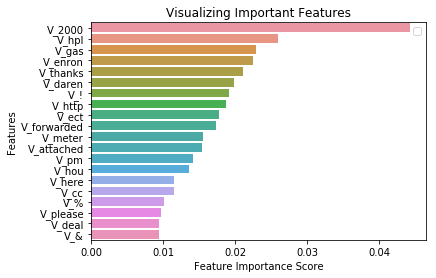

In [235]:
# Creating a bar plot
sns.barplot(x=feature_imp[:20], y=feature_imp[:20].index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

### 18. Term Frequency Inverse Data Frequency 

In [291]:
# Create frequency distribution of the top 50 words from both data sets.
# Since the word frequency items are a pair of (word, frequency), 
# we can use item[0] to get the word and item[1] to get the frequency.  
# Printing the string ‘\t’ inserts a tab into the output, 
# so that the frequency numbers line up.

## Using Spam
fdist = nltk.FreqDist(all_words_list)
fdistkeys = list(fdist.keys())
fdistkeys[:2000]

topkeys = fdist.most_common(2000)
#for pair in topkeys:
    #print(pair)

# Normalize
numwords = len(all_words_list)
topkeysnormalized = [(word, freq / numwords) for (word, freq) in topkeys]
topkeysnormalized[:20]

[('-', 0.0702740884113106),
 ('.', 0.04647767469799106),
 ('/', 0.03455722040534828),
 (',', 0.0318569378629113),
 (':', 0.022492157778815993),
 ('the', 0.02085836169881421),
 ('to', 0.016091848539455826),
 ('ect', 0.011857883378940576),
 ('and', 0.011355925604574072),
 ('of', 0.009570568866938085),
 ('@', 0.00898518320763532),
 ('a', 0.008828060691005361),
 ('for', 0.008113361810051392),
 ('?', 0.007316625508910098),
 ('you', 0.007146988809539701),
 ('in', 0.00712335090880776),
 ('this', 0.006212596498253576),
 ('is', 0.006201472780262075),
 ('hou', 0.00616810162628757),
 ('on', 0.005621648979955061)]

In [292]:
# use document_features function to create unigram feature sets for all sentences
TFIDF_featuresets = [(TFIDF_document_features(d, word_features), c) for (d, c) in emaildocs]

In [294]:
len(TFIDF_featuresets[0][0])

2000

In [288]:
print(TFIDF_featuresets[0][0])
print(TFIDF_featuresets[0][1])

{'V_-': 0, 'V_.': 0.04647767469799106, 'V_/': 0.03455722040534828, 'V_,': 0.0318569378629113, 'V_:': 0.022492157778815993, 'V_the': 0.02085836169881421, 'V_to': 0.016091848539455826, 'V_ect': 0, 'V_and': 0, 'V_of': 0.009570568866938085, 'V_@': 0, 'V_a': 0, 'V_for': 0.008113361810051392, 'V_?': 0, 'V_you': 0.007146988809539701, 'V_in': 0, 'V_this': 0.006212596498253576, 'V_is': 0, 'V_hou': 0, 'V_on': 0, 'V_i': 0.004681694809673185, "V_'": 0, 'V_)': 0, 'V_=': 0, 'V_(': 0, 'V_enron': 0, 'V_Subject': 0.0041713942468130545, 'V_!': 0, 'V_be': 0.004014271730183096, 'V_your': 0, 'V_2000': 0.003929453380497897, 'V_that': 0, 'V_with': 0.003481723731339963, 'V_from': 0, 'V__': 0, 'V_will': 0.003111860108122539, 'V_have': 0.003071536630403346, 'V_we': 0, 'V_s': 0, 'V_as': 0, 'V_are': 0.002881042959798883, 'V_it': 0, 'V_$': 0, 'V_>': 0, 'V_or': 0, 'V_3': 0, 'V_at': 0, 'V_not': 0, 'V_by': 0, 'V_please': 0, 'V_``': 0, 'V_com': 0, 'V_if': 0.0023498854257046876, 'V_|': 0, 'V_1': 0, 'V_;': 0, 'V_#': 0, 

In [293]:
# train the classifier using these features
train_set, test_set = TFIDF_featuresets[2700:], TFIDF_featuresets[:2700]
classifier = nltk.NaiveBayesClassifier.train(train_set)
nltk.classify.accuracy(classifier, test_set)

0.9596296296296296